In [1]:
%matplotlib inline 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.optim.lr_scheduler as sched

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [130]:
vgg = list(torchvision.models.vgg19(pretrained=True).features[:-1].children())
vgg = nn.Sequential(*[nn.AvgPool2d(2) if isinstance(n, nn.MaxPool2d) else n for n in vgg]).to(dev)
#vgg = nn.Sequential(*vgg).to(dev)
for param in vgg.parameters():
    param.requires_grad = False
vgg.eval();

In [131]:
# All conv layers. Added +1 for incorporating ReLU
layer_ids = [int(idx)+1 for idx, m in vgg.named_children() if isinstance(m, nn.Conv2d)]
len(layer_ids)

16

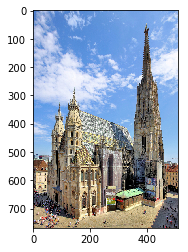

In [132]:
p = np.array(Image.open('stephansdom_small.png'))
plt.imshow(p)
plt.show()

In [133]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

tnorm = transforms.Compose([
    transforms.ToTensor(), # 0..1
    transforms.Normalize(mean=mean, std=std)    
])

class Denormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
class Clip:
    def __call__(self, tensor):
        return torch.clamp(tensor, min=0., max=1.)
    
class ToNumpy():
    def __call__(self, tensor):
        t = np.transpose(tensor.detach().numpy(), (1, 2, 0))
        t *= 255.
        return t.astype(np.uint8)
        
tdenorm = transforms.Compose([
    Denormalize(mean=mean, std=std),
    Clip(),
    ToNumpy()    
])

In [140]:
from tqdm import tqdm

def norm(x, alpha=2):       
    return (x**alpha).sum()

def tv_norm(x, beta):
    tl = x[..., :-1, :-1]
    tr = x[..., :-1,  1:]
    bl = x[..., 1:,  :-1]
    
    tv = ((tl - tr)**2 + (tl - bl)**2)**(beta*0.5)
    return tv.sum()
        
def max_lr(opt):
    return max([g['lr'] for g in opt.param_groups])    

def reconstruct_image(net, dev, image, niter=700, lr=1e4, lam_alpha=1e-8, lam_t=1e-8):
    '''Reconstruct an image from a neural representation.
    
    Based on
    Understanding Deep Image Representations by Inverting Them
    https://arxiv.org/abs/1412.0035    
    '''
    
    image = image.to(dev).unsqueeze(0)
    x = torch.tensor(torch.randn_like(image), requires_grad=True).to(dev)
    
    opt = optim.Adam([x], lr=lr)
    scheduler = sched.ReduceLROnPlateau(opt, 'min', threshold_mode='abs', threshold=1e-3, patience=20, cooldown=50, min_lr=1e-3)
    
    rep_target = net(image)
    
    alpha = 2.
    beta = 2.
    
    images = []
    
    with tqdm(total=niter) as t: 
        for idx in range(niter):
            opt.zero_grad()
            
            rep_x = net(x)
            
            eloss = norm(rep_x - rep_target, 2) / norm(rep_target)
            aloss = norm(x, alpha)
            tloss = tv_norm(x, beta)
            loss = eloss + lam_alpha * aloss + lam_t * tloss
            loss.backward()
            
            opt.step()
            
            t.set_postfix(loss=loss.item(), grad=torch.abs(x.grad).max().item(), lr=max_lr(opt))
            t.update()            
            
            scheduler.step(loss)
            
            if idx % 50 == 0:
                images.append(x.clone())
    
    return images

100%|██████████████████████████████████████████| 500/500 [00:32<00:00, 14.94it/s, grad=1.08e-06, loss=0.0307, lr=0.001]


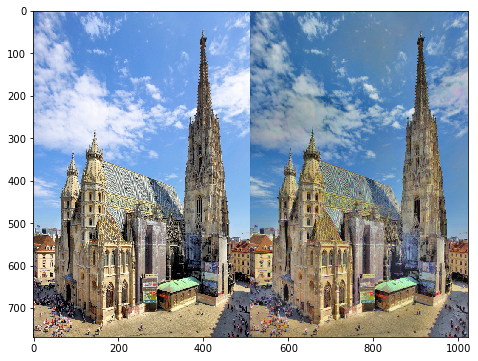

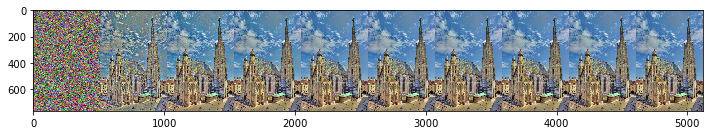

In [142]:
net = vgg[:layer_ids[4]]
images = reconstruct_image(net, dev, tnorm(p), niter=500, lr=1e0, lam_alpha=0, lam_t=1e-7)
images = [tdenorm(x.squeeze().cpu()) for x in images]

plt.figure(figsize=(12,6))
plt.imshow(np.hstack((p, images[-1])))
plt.show()

plt.figure(figsize=(12,6))
plt.imshow(np.hstack(images))
plt.show()